# Seam Carving
Because I saw a presentation on it and though it was cool.
---
Here's the libraries I used, split into algorithm and notebook specific groups:

In [109]:
# NOTEBOOK SPECIFIC
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# ALGORITHM SPECIFIC
import cv2 as cv
from operator import itemgetter

## 1. Finding a detail map
Here's the image that I'll use for testing:

Text(0.5, 1.0, 'Original Image')

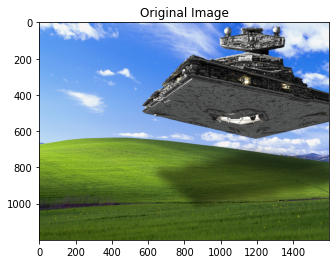

In [110]:
# Function to convert images from BGR (OpenCV) to RGB (matplotlib)
def BGR2RGB(img):
    return cv.cvtColor(img, cv.COLOR_BGR2RGB)

# Open image
testImg = cv.imread("images/TestImg.jpeg")

# Display image
plt.figure()
plt.imshow(BGR2RGB(testImg))
plt.title("Original Image")

Next I'll identify where the most detail is by perfoming some simple Canny Edge Detection.

Text(0.5, 1.0, 'Detail Map (Edges)')

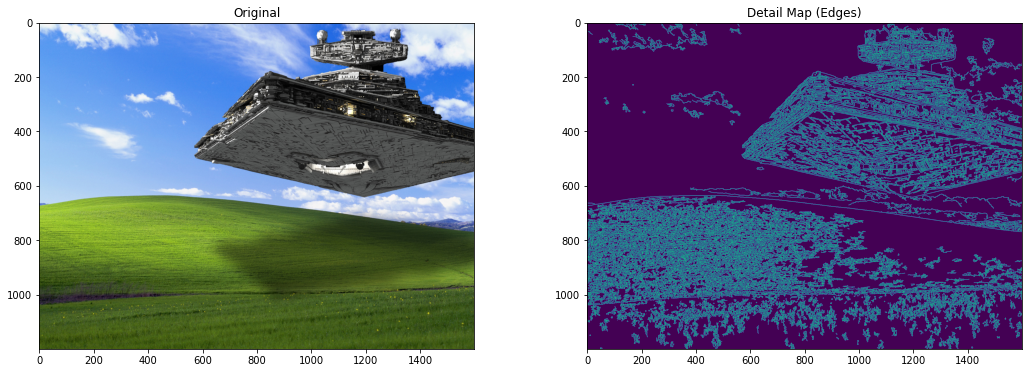

In [111]:
# Edge detection
edges = cv.Canny(testImg, 10, 150)

# Display
_, (x1, x2) = plt.subplots(1, 2, figsize=(18, 6))
x1.imshow(BGR2RGB(testImg))
x1.set_title("Original")

x2.imshow(edges)
x2.set_title('Detail Map (Edges)')

## 2. Finding carving lines
To better illustrate this process, I'll use a simpler 10x10 image *(which I'll say is the detail map for some random image)*

Text(0.5, 1.0, 'Carving Demo')

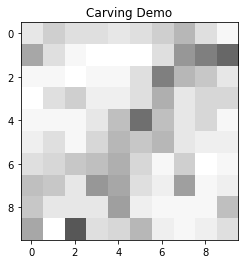

In [112]:
# Open image
carvingDemo = cv.cvtColor(cv.imread("images/Simple10X10.png"), cv.COLOR_BGR2GRAY)

# Display image
plt.figure()
plt.imshow(BGR2RGB(carvingDemo))
plt.title("Carving Demo")

Carving lines are calculated for each X value in the position:
1. Start at the origin (X, 0).
2. Proceed to the neighbour with the lowest detail value where Y = Y+1.
3. Repeat until the top of the image is reached

Here is the process done while X = 0:

Text(0.5, 1.0, 'Carving Line (sum = 1703)')

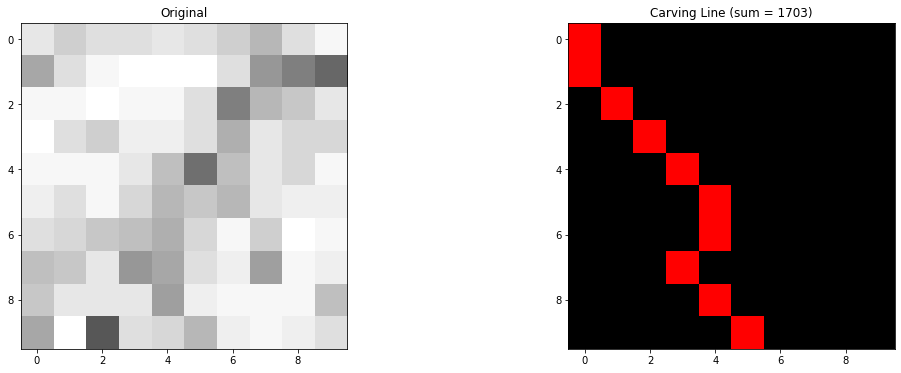

In [113]:
def FindCarvingLine(img, x):
    # Get dimensions of image
    height, width = img.shape

    # Carving line coordinates
    carvingLine = [(0,x)]
    sum = 0

    # Iterate through the image rows
    for i in range(height-1):
        # Get pixel values of neighbours
        values = []
        for neighbourX in range(3):
            neighbourX = x + (neighbourX - 1)
            if neighbourX >= 0 and neighbourX < width:
                neighbourCoordinates = (i+1, neighbourX)
                neighbourValue = img[neighbourCoordinates]
                values.append([neighbourValue, neighbourX])
        
        # Choose neighbour with lowest value
        lowest = [255, -1]
        for neighbour in values:
            if neighbour[0] <= lowest[0]:
                lowest = neighbour
        
        # Add to sum
        sum = sum + lowest[0]

        # Repeat with new coordinates
        carvingLine.append((i+1, lowest[1]))
        x = lowest[1]
    
    # Return the line and the sum
    return carvingLine, sum

# Get carving line
newLine, sum = FindCarvingLine(carvingDemo, 0)

# Create debug image with line points
annotated = np.zeros((10,10,3), np.uint8)
for point in newLine:
    annotated[point] = (0,0,255)

# Display
_, (x1, x2) = plt.subplots(1, 2, figsize=(18, 6))
x1.imshow(BGR2RGB(carvingDemo))
x1.set_title("Original")

x2.imshow(BGR2RGB(annotated))
x2.set_title("Carving Line (sum = " + str(sum) + ")")


Once a carving line is found for each x value in the image, the lines are then ranked in ascending order by their sum.

Sorted Lines


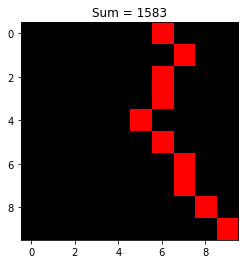

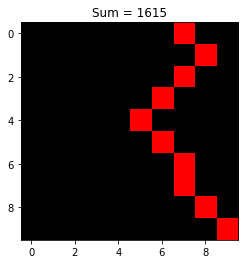

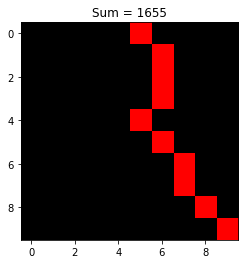

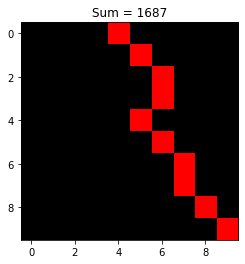

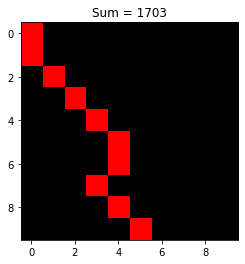

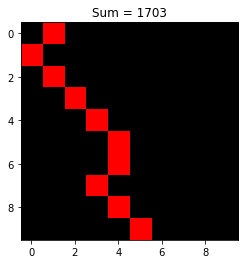

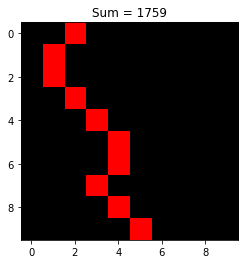

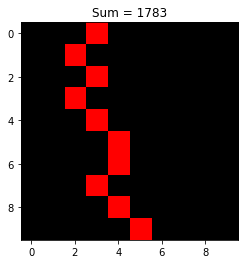

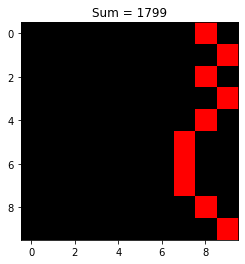

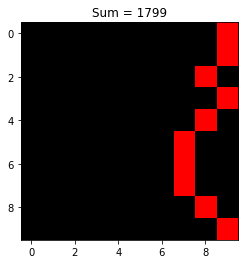

In [114]:
# Generate all carving lines
carvingLines = []
for x in range(carvingDemo.shape[1]):
    line, sum = FindCarvingLine(carvingDemo, x)
    carvingLines.append((line, sum))

# Sort by sum
carvingLines = sorted(carvingLines, key=itemgetter(1))

# Display
print("Sorted Lines")
for line in carvingLines:
    annotated = np.zeros((10,10,3), np.uint8)
    for point in line[0]:
        annotated[point] = (0,0,255)
    
    plt.figure()
    plt.imshow(BGR2RGB(annotated))
    plt.title("Sum = " + str(line[1]))


## 3. Removing carving lines from images
The pixels are removed from the carving lines in their sorted order until the desired width is reached.

By removing one carving line from the 10x10 image, I'll get a resized 9x10 image.

Text(0.5, 1.0, 'Resized')

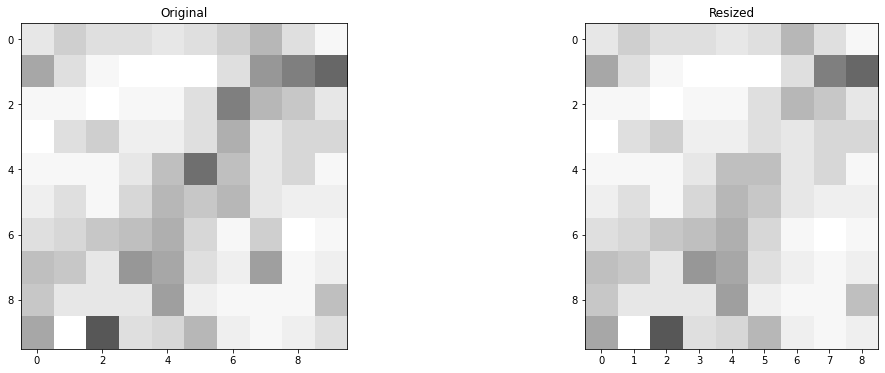

In [115]:
def ShiftPixels(x, y, width, img):
    if x+1 < width:
        img[y, x] = img[y, x+1]
        img = ShiftPixels(x+1, y, width, img)
    return img

def RemovePoints(line, img):
    # Create copy image
    copy = img.copy()

    # Get image dimensions
    height, width = img.shape[:2]

    # Get x,y of each point
    for point in line[0]:
        y = point[0]
        x = point[1]

        # Shift neighbouring pixels to the left (if applicable)
        copy = ShiftPixels(x,y,width,copy)
    
    # Remove last collumn
    copy = copy[0:height, 0:width-1]

    return copy

resized = RemovePoints(carvingLines[0], carvingDemo)

# Display
_, (x1, x2) = plt.subplots(1, 2, figsize=(18, 6))
x1.imshow(BGR2RGB(carvingDemo))
x1.set_title("Original")

x2.imshow(BGR2RGB(resized))
x2.set_title("Resized")

Here's the final code (which can be found and run from the .py script in this repository):

In [116]:
import cv2 as cv
from operator import itemgetter

def FindCarvingLine(img, x):
    # Get dimensions of image
    height, width = img.shape

    # Carving line coordinates
    carvingLine = [(0,x)]
    sum = 0

    # Iterate through the image rows
    for i in range(height-1):
        # Get pixel values of neighbours
        values = []
        for neighbourX in range(3):
            neighbourX = x + (neighbourX - 1)
            if neighbourX >= 0 and neighbourX < width:
                neighbourCoordinates = (i+1, neighbourX)
                neighbourValue = img[neighbourCoordinates]
                values.append([neighbourValue, neighbourX])
        
        # Choose neighbour with lowest value
        lowest = [255, -1]
        for neighbour in values:
            if neighbour[0] <= lowest[0]:
                lowest = neighbour
        
        # Add to sum
        sum = sum + lowest[0]

        # Repeat with new coordinates
        carvingLine.append((i+1, lowest[1]))
        x = lowest[1]
    
    # Return the line and the sum
    return carvingLine, sum

def ShiftPixels(x, y, width, img):
    if x+1 < width:
        img[y, x] = img[y, x+1]
        img = ShiftPixels(x+1, y, width, img)
    return img

def RemovePoints(line, img):
    # Create copy image
    copy = img.copy()

    # Get image dimensions
    height, width = img.shape[:2]

    # Get x,y of each point
    for point in line[0]:
        y = point[0]
        x = point[1]

        # Shift neighbouring pixels to the left (if applicable)
        copy = ShiftPixels(x,y,width,copy)
    
    # Remove last collumn
    copy = copy[0:height, 0:width-1]

    return copy

def Resize(img, newWidth):
    # Create copy so a comparison is possible
    img = img.copy()

    # Edge detection
    edges = cv.Canny(img, 10, 150)

    # Generate all carving lines
    imgWidth = edges.shape[1]
    carvingLines = []
    for x in range(imgWidth):
        line, sum = FindCarvingLine(edges, x)
        carvingLines.append((line, sum))

    # Sort by sum
    carvingLines = sorted(carvingLines, key=itemgetter(1))

    # Calculate the amount of lines needed to remove
    lineCount = imgWidth - newWidth

    #... and remove those lines from the picture
    for i in range(lineCount):
        img = RemovePoints(carvingLines[i], img)
    
    return img

    

... and here is the final result on the image from before:

Text(0.5, 1.0, 'Resized')

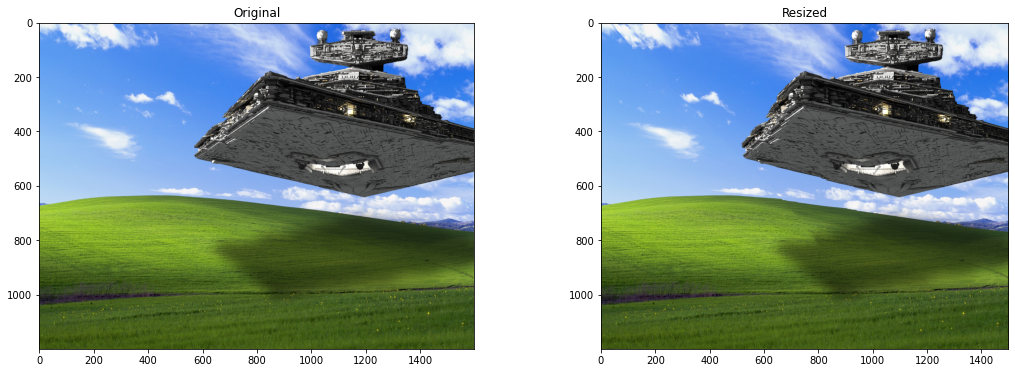

In [118]:
resized = Resize(testImg, 1500)

# Display
_, (x1, x2) = plt.subplots(1, 2, figsize=(18, 6))
x1.imshow(BGR2RGB(testImg))
x1.set_title("Original")

x2.imshow(BGR2RGB(resized))
x2.set_title("Resized")

It's nowhere near perfect as the more you wish to remove the more distorted it becomes, but for all intents and purposes, it works.